In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [2]:
# hyperparameter
height = 256
width = 256
channels = 3
batch_size = 128
img_shape = (height, width, channels)
img_size = (height, width)

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory('/kaggle/input/food-ingredients/Food Dataset/train',
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory('/kaggle/input/food-ingredients/Food Dataset/val',
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('food_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 20057 files belonging to 55 classes.
Found 5186 files belonging to 55 classes.
['Alpukat', 'Anggur', 'Apel', 'Asparagus', 'Brokoli', 'Buah naga', 'Ceker ayam', 'Dada ayam', 'Durian', 'Jagung', 'Jambu Air', 'Jeruk', 'Kacang Mete', 'Kacang polong', 'Kacang tanah', 'Kangkung', 'Kelapa', 'Kembang Kol', 'Kentang', 'Klengkeng', 'Kulit ayam', 'Labu', 'Labu Siam', 'Leci', 'Lemon', 'Lobak Merah', 'Mangga', 'Melon', 'Mentimun', 'Nanas', 'Nangka', 'Nasi merah', 'Nasi putih', 'Paha bawah ayam', 'Paprika', 'Pare', 'Pepaya', 'Pir', 'Pisang', 'Pokcoy', 'Pork belly', 'Rambutan', 'Salmon', 'Sayap Ayam', 'Semangka', 'Singkong', 'Stroberi', 'Tahu', 'Tauge', 'Telur', 'Tempe', 'Terong', 'Tomat', 'Ubi', 'Wortel']


In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomBrightness(0.1),
                                         tf.keras.layers.RandomZoom(0.2)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

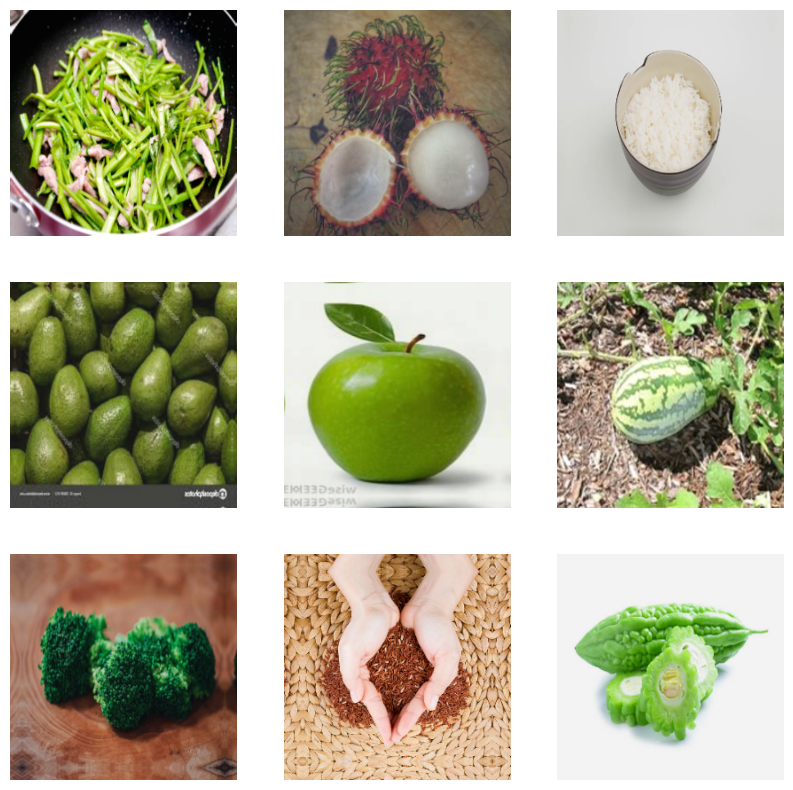

In [5]:
#Define a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50

# load pre-trained model
pre_trained = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [7]:
x = pre_trained.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

food_model = tf.keras.models.Model(inputs = pre_trained.input,
                                   outputs = predictions
                                  )

food_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
                  )

food_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [8]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 10, 
                                        mode = 'min', 
                                        restore_best_weights = True)

history = food_model.fit(train_ds,
                         validation_data = val_ds,
                         epochs = 100,
                         callbacks = [early_stopping_callback]
                        )

Epoch 1/100
157/157 [==============================] - 312s 2s/step - loss: 1.1643 - accuracy: 0.6928 - val_loss: 0.6207 - val_accuracy: 0.8241
Epoch 2/100
157/157 [==============================] - 255s 2s/step - loss: 0.4759 - accuracy: 0.8646 - val_loss: 0.5357 - val_accuracy: 0.8506
Epoch 3/100
157/157 [==============================] - 254s 2s/step - loss: 0.3430 - accuracy: 0.9033 - val_loss: 0.5837 - val_accuracy: 0.8544
Epoch 4/100
157/157 [==============================] - 249s 2s/step - loss: 0.2680 - accuracy: 0.9200 - val_loss: 0.5259 - val_accuracy: 0.8727
Epoch 5/100
157/157 [==============================] - 250s 2s/step - loss: 0.2262 - accuracy: 0.9347 - val_loss: 0.4394 - val_accuracy: 0.8901
Epoch 6/100
157/157 [==============================] - 250s 2s/step - loss: 0.1883 - accuracy: 0.9448 - val_loss: 0.4777 - val_accuracy: 0.8893
Epoch 7/100
157/157 [==============================] - 250s 2s/step - loss: 0.1775 - accuracy: 0.9477 - val_loss: 0.6139 - val_accuracy:

41/41 [==============================] - 19s 391ms/step - loss: 0.4394 - accuracy: 0.8901


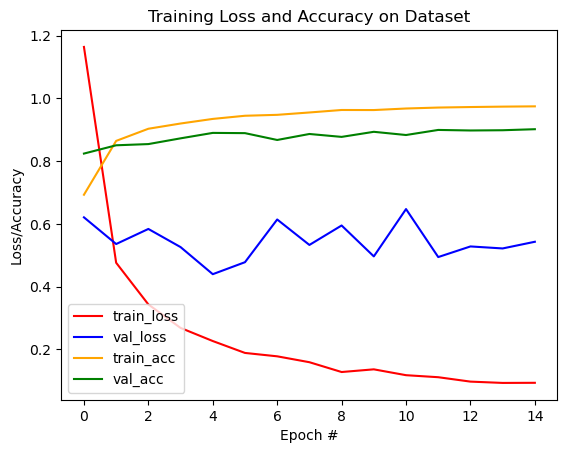

In [9]:
model_evaluation = food_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [10]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [11]:
current_datetime = datetime.now()

# Save Model
food_model.save(f'food_model_{current_datetime}')

# Save .h5 model
food_model.save(f'food_model_{current_datetime}.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(f'./food_model_{current_datetime}')
tflite_model = converter.convert()

# Save the tflite model
with open(f'food_model_{current_datetime}.tflite', 'wb') as f:
    f.write(tflite_model)

In [12]:
count = 0

for root_dir, cur_dir, files in os.walk('/kaggle/input/food-ingredients/Food Dataset/test'):
    count += len(files)

ds = tf.keras.utils.image_dataset_from_directory('/kaggle/input/food-ingredients/Food Dataset/test',
                                                 labels='inferred',
                                                 label_mode='categorical',
                                                 subset='validation',
                                                 image_size=img_size,
                                                 shuffle=True,
                                                 validation_split=0.25,
                                                 batch_size=int(count/4),
                                                 seed=127
                                                )

#define labels for testing
for images, test_labels in ds.take(1):  # only take first element of dataset
#     numpy_images = images.numpy()
    y_labels = test_labels.numpy()

y_labels = np.argmax(y_labels, axis=1)

#make prediction
y_preds = np.argmax(food_model.predict(ds), axis=1)

#get classification report
print(classification_report(y_labels, y_preds, target_names=labels))

Found 2576 files belonging to 55 classes.
Using 644 files for validation.
1/1 [==============================] - 7s 7s/step
                 precision    recall  f1-score   support

        Alpukat       0.00      0.00      0.00        14
         Anggur       0.12      0.12      0.12        16
           Apel       0.00      0.00      0.00        15
      Asparagus       0.00      0.00      0.00        17
        Brokoli       0.07      0.06      0.06        16
      Buah naga       0.00      0.00      0.00        12
     Ceker ayam       0.00      0.00      0.00        12
      Dada ayam       0.00      0.00      0.00        19
         Durian       0.00      0.00      0.00        10
         Jagung       0.07      0.06      0.06        18
      Jambu Air       0.00      0.00      0.00        13
          Jeruk       0.00      0.00      0.00        11
    Kacang Mete       0.00      0.00      0.00        11
  Kacang polong       0.09      0.10      0.10        10
   Kacang tanah     

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (20,12))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

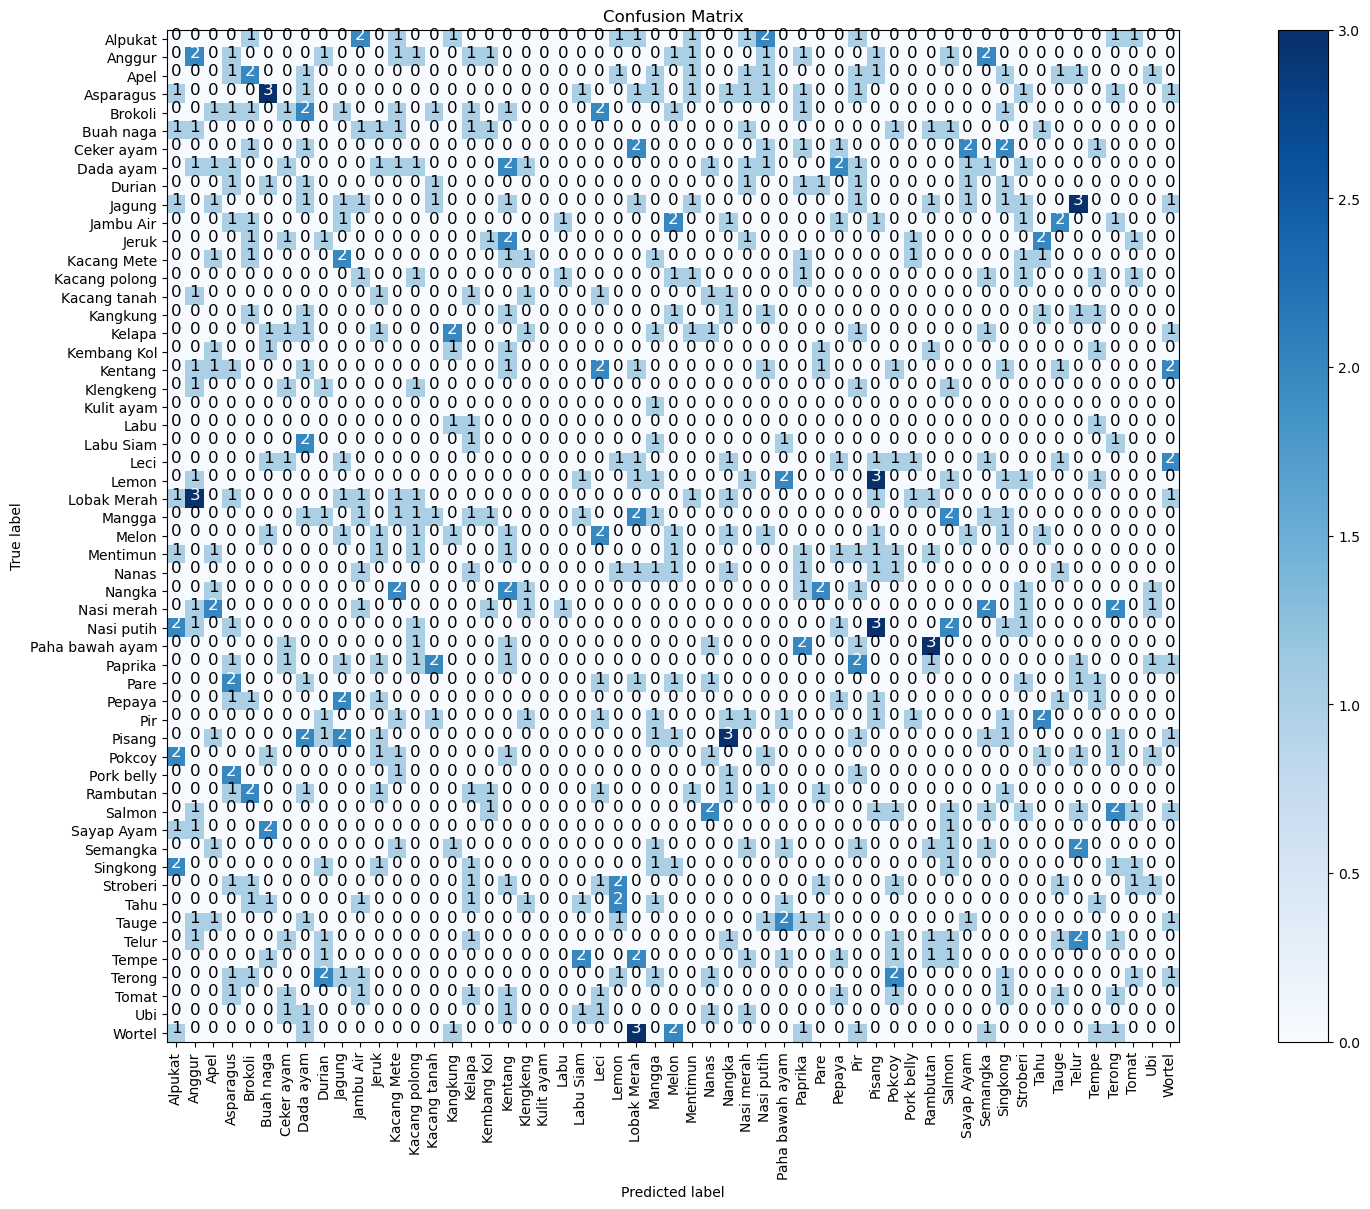

In [14]:
#get confusion matrix
cm = confusion_matrix(y_labels, y_preds)
# print(cm)

#plot
plot_confusion_matrix(cm, labels, normalize=False)

Kelapa/66.jpg
1/1 [==============================] - 1s 1s/step
[2.3690666e-06 1.8112793e-07 3.3936355e-02 2.8849968e-07 9.8485053e-10
 2.3312571e-06 9.9396304e-11 1.8379011e-06 1.6775935e-08 3.6804144e-09
 1.5731688e-05 2.8647523e-07 8.6189900e-09 5.3666718e-06 2.6968287e-08
 6.1802736e-09 8.9194113e-01 2.5533995e-11 1.1311486e-06 9.3762003e-07
 8.0028614e-12 4.9505653e-09 8.1779508e-09 1.4848961e-09 1.7939622e-06
 1.3268624e-07 7.3552452e-02 1.1823392e-09 1.1443653e-06 3.6267913e-09
 1.2652742e-07 8.8894998e-09 2.0153000e-10 3.9148657e-10 4.1980716e-08
 4.0583809e-10 1.3758197e-04 3.9243686e-04 4.2789448e-08 5.7915150e-10
 3.6673597e-09 3.8141149e-08 2.8929728e-07 9.0507359e-12 4.1443954e-07
 1.4570841e-09 1.3351742e-07 1.6411750e-08 1.6995931e-09 9.5119260e-11
 4.6082735e-07 6.3433530e-09 4.2247325e-06 6.1345185e-07 3.1771847e-09]
predicted food: Kelapa 
confidence: 0.8919411301612854 


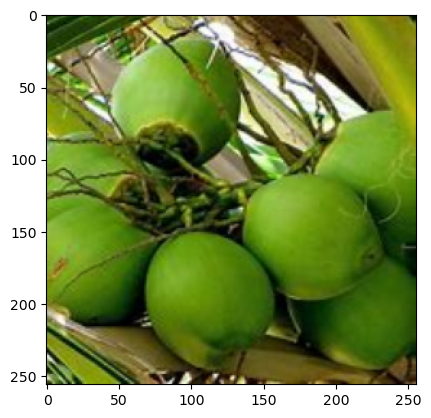

In [15]:
random_classes_names = random.choice(os.listdir('/kaggle/input/food-ingredients/Food Dataset/test'))
random_file = random.choice(os.listdir(f'/kaggle/input/food-ingredients/Food Dataset/test/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}')

img_test = cv2.imread(f'/kaggle/input/food-ingredients/Food Dataset/test/{random_classes_names}/{random_file}')
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (img_size))
plt.imshow(img_test)

prediction = food_model.predict(np.expand_dims(img_test, axis=0))[0]
predicted_label = np.argmax(prediction)

print(prediction)
print(f'predicted food: {labels[predicted_label]} \nconfidence: {prediction[predicted_label]} ')